In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

## Загрузка данных и предварительный анализ

В "боевой" версии данный скрипт должен обращаться напрямую к БД и считывать данные из необходимой таблицы, как это показано в блоке ниже. Но для упрощения моделирования ситуации, мы возьмём данные из заготовленного заранее .csv файла.

In [2]:
#cnx = sqlite3.connect('Data/db.sqlite3') #тут путь к БД
#df = pd.read_sql_query("SELECT * FROM admin_panel_result", cnx)

In [3]:
df = pd.read_csv('Data/data.csv')
df.head()

,Unnamed: 0,correct_answer,spent_time,pass_date,num_attempt,course_id,question_id,topic_id,user_id,is_ok
0,0,0,30000000,2020-05-09 12:54:57.638181,0,1,1,1,1,1
1,1,0,24000000,2020-05-09 12:54:57.657616,0,1,2,1,1,1
2,2,0,28000000,2020-05-09 12:54:57.667589,0,1,3,1,1,1
3,3,0,67000000,2020-05-09 12:54:57.681554,0,1,4,1,1,1
4,4,0,55000000,2020-05-09 12:54:57.692524,0,1,5,1,1,0


In [4]:
df.head()

,Unnamed: 0,correct_answer,spent_time,pass_date,num_attempt,course_id,question_id,topic_id,user_id,is_ok
0,0,0,30000000,2020-05-09 12:54:57.638181,0,1,1,1,1,1
1,1,0,24000000,2020-05-09 12:54:57.657616,0,1,2,1,1,1
2,2,0,28000000,2020-05-09 12:54:57.667589,0,1,3,1,1,1
3,3,0,67000000,2020-05-09 12:54:57.681554,0,1,4,1,1,1
4,4,0,55000000,2020-05-09 12:54:57.692524,0,1,5,1,1,0


In [5]:
del df['Unnamed: 0']
df.head()

,correct_answer,spent_time,pass_date,num_attempt,course_id,question_id,topic_id,user_id,is_ok
0,0,30000000,2020-05-09 12:54:57.638181,0,1,1,1,1,1
1,0,24000000,2020-05-09 12:54:57.657616,0,1,2,1,1,1
2,0,28000000,2020-05-09 12:54:57.667589,0,1,3,1,1,1
3,0,67000000,2020-05-09 12:54:57.681554,0,1,4,1,1,1
4,0,55000000,2020-05-09 12:54:57.692524,0,1,5,1,1,0


In [6]:
df.describe()

,correct_answer,spent_time,num_attempt,course_id,question_id,topic_id,user_id,is_ok
count,30.000000,3.000000e+01,30.0,30.0,30.000000,30.0,30.000000,30.000000
mean,0.566667,4.563333e+07,0.0,1.0,5.500000,1.0,1.333333,0.733333
std,0.504007,2.685656e+07,0.0,0.0,2.921384,0.0,0.479463,0.449776
min,0.000000,1.000000e+07,0.0,1.0,1.000000,1.0,1.000000,0.000000
25%,0.000000,2.475000e+07,0.0,1.0,3.000000,1.0,1.000000,0.250000
50%,1.000000,3.400000e+07,0.0,1.0,5.500000,1.0,1.000000,1.000000
75%,1.000000,6.700000e+07,0.0,1.0,8.000000,1.0,2.000000,1.000000
max,1.000000,9.700000e+07,0.0,1.0,10.000000,1.0,2.000000,1.000000


Убрав лишние данные и изучим получившийся датасет. Имеем следующие данные:
1. correct_answer. Правильность ответа, который дал пользователь. 0 - неверно, 1 - верно.
2. spent_time. Сколько времени потратил пользователь на данном вопросе.
3. pass_date. Точная дата и время, когда был дан ответ.
4. num_attempt. Номер попытки.
5. course_id.  ID курса, которому принадлежит вопрос.
6. topic_id. ID темы, которой принадлежит вопрос.
6. question_id. ID вопроса.
7. user_id. ID пользователя.
8. is_ok. Корректность вопроса. Вопрос может быть некорректно поставлен, или в базе знаний сайта может не хватать необходимой информации, чтобы ответить на него верно. Выражаясь проще, мы можем сказать что вопрос некорректен в том случае, если люди на него редко отвечают правильно, либо если они долго над ним думают и так далее. Это будет целевой параметр. Построим модель, которая по всем полям указанным выше, будет предсказывать значение поля is_ok. 

Подведем итог. Зная действия пользователя в системе адаптации, постараемся построить модель, которая поможет:
1. Упростить контроль за выполнением заданий и созданием вопросов.
2. Построит наглядную инфографику для администратора системы.
3. Сможет выявлять некорректные вопросы. Это даст возможность таргетированного выявления пробелов в построении учебного процесса (что, в свою очередь, позволит составителю базы знаний яснее понимать что и где надо исправить). 

## Построим инфографику

В первую очередь посмотрим на соотношение правильных ответов к неправильным. Предусмотрим возможность фильтрации для вывода на график. На данном графике можно настроить:
1. ID курса. Можно выбрать курс с определенным номером, либо же использовать информацию обо всех курсах. Тогда переменная должна хранить в себе значение 'all'
2. ID темы. Тот же функционал что выше, только для тем.
3. ID пользователя. Тот же функционал что выше, только для пользователя.
4. Период анализа. Переменные start_date и stop_date указывают даты, которые формируют период, за который мы хотим посмотреть отчётность.

In [7]:
course =1
topic = 1
question = 'all'
id = 'all'
start_date = '2020-05-01'
stop_date = '2020-05-10'

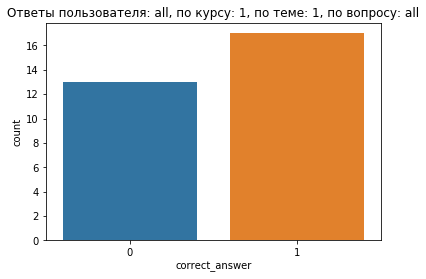

In [8]:
if id != 'all':
        df = df[df['user_id'] == id]
if course != 'all':
        df = df[df['course_id'] == course]
if topic != 'all':
    df = df[df['topic_id'] == topic]
df = df[df['pass_date'] >= start_date]
df = df[df['pass_date'] <= stop_date]
    
plt.title("Ответы пользователя: " + str(id) + ", по курсу: " + str(course)
              + ", по теме: " + str(topic) + ", по вопросу: " + str(question))
sns.countplot(x='correct_answer', data=df)

Затем построим график, на котором выведем стреднее время ответа на каждый вопрос, интересуемого нас теста. Предусмотрим такой же функционал с фильтрацией по пользователям, курсам и темам.

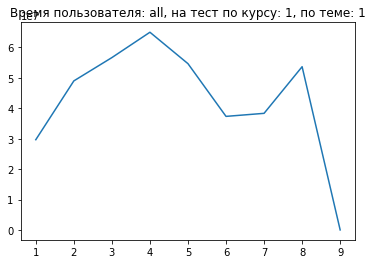

In [9]:
time = [0] * 10
for i in range(0, 9):
    buf = df[df['question_id'] == i]
    time[i] = buf['spent_time'].mean()
plt.title("Время пользователя: " + str(id) + ", на тест по курсу: " + str(course)
              + ", по теме: " + str(topic))
plt.plot(time)

## Построим модель 

Для построения модели удалим лишние данные из датасета. Маловероятно, что поле pass_date коррелирует с корректностью постановки вопроса, поэтому считаем его за "лишние данные"

In [10]:
del df['pass_date']
df.head()

,correct_answer,spent_time,num_attempt,course_id,question_id,topic_id,user_id,is_ok
0,0,30000000,0,1,1,1,1,1
1,0,24000000,0,1,2,1,1,1
2,0,28000000,0,1,3,1,1,1
3,0,67000000,0,1,4,1,1,1
4,0,55000000,0,1,5,1,1,0


Выделим целевой параметр - поле is_ok

In [11]:
y_train = df.pop('is_ok')

Построим модель. В качестве классификатора будем использовать решающие деревья. Выбор этой модели обусловлен следующими параметрами:
1. Простота реализации. Для классификатора такого рода достаточно имеющейся у нас информации и нет необходимости в нормализации данных.
2. Не требует больших вычислительных ресурсов. Поскольку подразумевается, что модель будет работать либо на сайте, либо должна быть жестко связана с базой данных сайта, то необходимо учитывать сложность компьютерных вычислений.

In [12]:
classifier = DecisionTreeClassifier()
classifier.fit(df, y_train)
predicted = classifier.predict(df)
print("Метрика Accuracy построенного классификатора: " + str(classifier.score(df, y_train)))
print("Вектор выходных значений классификатора: " + str(predicted))

Метрика Accuracy построенного классификатора: 1.0
Вектор выходных значений классификатора: [1 1 1 1 0 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1]


Для оценки качества работы смоделированной системы используется метрика Accuracy(точность). Она показывает соотношение правильных ответов ко всем возможным ответам системы. Значение Accuracy = 1 говорит о том, что система дала только верные ответы. То есть на показала 100 процентную точность на тренировочном датасете. 

Далее интерпретируем вектор выходных значений в понятную человеку информацию. Для этого посчитаем коэф. уверенности для каждого вопроса, который будет отображать как часто система назвала определенный вопрос некорректным.

In [13]:
confidence_score = [0] * 10
iterator = 0
for i in range(0, len(predicted)-1):
    if predicted[i] == 0:
        confidence_score[iterator] = confidence_score[iterator] + 1
    iterator += 1
    if iterator == 10:
        iterator = 0
        
confidence_score

[0, 0, 2, 0, 3, 0, 0, 3, 0, 0]

Затем пронормируем этот коэф. для каждого вопроса и после нормировки сравним его с порогом, выше которого считаем вопрос некорректным, ниже корректным.

In [14]:
norm = max(confidence_score)
threshold = 0.5 
for i in range (0, len(confidence_score)): 
    confidence_score[i] = confidence_score[i] / norm
    if confidence_score[i] > 0.5:
        confidence_score[i] = 1
    else:
        confidence_score[i] = 0
confidence_score

[0, 0, 1, 0, 1, 0, 0, 1, 0, 0]

In [15]:
print("В курсе " + str(course) + ", в теме " + str(topic)+ " вызывают затруднения вопросы:")
for i in range(0, len(confidence_score)):
    if confidence_score[i] == 1:
        print(str(i+1) + " ")

В курсе 1, в теме 1 вызывают затруднения вопросы:
3 
5 
8 


Выходные значения построенной модели полностью соответствуют исследуемому датасету. Поскольку при формировании анализируемой в данной работе таблицы данных, в неё предумышленно были внесены изменения, такие как:
1. Для 3, 5 и 8-ых вопросов было увеличено время, за которое наши воображаемые пользователи дали ответ.
2. В этих вопросах пользователи ошибались чаще, либо дольше не могли дать правильный ответ.
3. Остальные данные имели случайное нормальное распределение. То есть, в среднем для ответа на остальные вопросы требовалось меньше времени и в них пользователи реже ошибались.